<center> <h1>Using GraphWave </h1> </center>

&nbsp;

&nbsp;

The goal of the  following notebook is to show how the GraphWave algorithm can be used. 

GraphWave was implemented in Python 2.7 and requires to load the following Python packages:

+ __pygsp__ (Graph signal Processing package from EPFL, to compute spectral graph wavelets.)
+ __networkx__ (for handling network objects: in particular, visualization, etc.)
+ traditional libraries for data analytics: __seaborn__ for plotting, __pandas__ for dataframes


In [1]:
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
from graphwave.graphwave import *


np.random.seed(123)


## I. Creating a graph

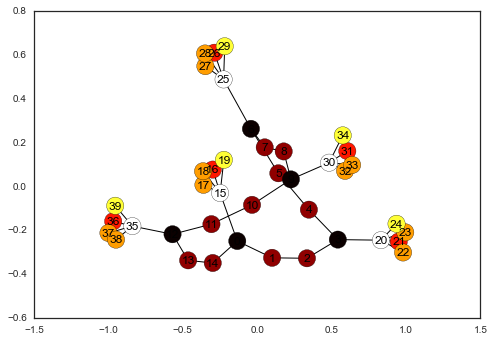

In [2]:
# 1- Start by defining our favorite regular structure

width_basis = 15
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 5  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [["house"]] * n_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 0
G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=True,
                                       savefig=False)

(Note: best visualization of the graphs are obtained using Gephi, or some other specialized graph visualization software)

## II. Running GraphWave


We propose here a simple demonstration of GraphWave using both the automatic version (part a) and the manual version. This shows how to use GraphWave in a parameter-free version, or giving the analyst the possibility to select an adequate scale value.

For each of these approaches, we compute the signature by calling GraphWave. We then compute its PCA projection to visualize the embeddings. Note that in this very simple examples, GraphWave recovers structura equivalence, as shown by the overlapping embeddings on the first principal components.

#### a. Multiscale GraphWave: Automatic selection of the range of scales

In [48]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 23 10:32:21 2018

@author: cdonnat
"""

import networkx as nx
import numpy as np
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
#from graphwave.graphwave import *
import time
np.random.seed(123)
import copy
import math

def compute_cheb_coeff(scale, order):
    coeffs = [(-scale)**k * 1.0 / math.factorial(k) for k in range(order + 1)]
    return coeffs

def compute_cheb_coeff_basis(scale, order):
    xx = np.array([np.cos((2*i-1)*1.0/(2*order) * math.pi) for i in range(1,order+1)])
    basis = [np.ones((1,order)),np.array(xx)]
    for k in range(order + 1-2):
        basis.append(2* np.multiply(xx, basis[-1]) - basis[-2])
    basis = np.vstack(basis)
    f = np.exp(-scale*(xx+1))
    products = np.einsum("j,ij->ij",f,basis)
    coeffs = 2.0/(order)*products.sum(1)
    coeffs[0] = coeffs[0]/2
    return list(coeffs)




def heat_diffusion_ind(graph, taus=[1, 10, 25, 50], diff_type='heat',order = 10, proc = 'approximate'):
    '''
    This method computes the heat diffusion waves for each of the nodes
    INPUT:
    -----------------------
    graph    :    Graph, can be of type networkx or pygsp
    taus     :    list of 4 scales for the wavelets. The higher the tau,
                  the better the spread
    order    :    order of the polynomial approximation

    OUTPUT:
    -----------------------
    heat     :     tensor of length  len(tau) x n_nodes x n_nodes
                   where heat[tau,:,u] is the wavelet for node u
                   at scale tau
    '''
    # Compute Laplacian

    a = nx.adjacency_matrix(graph)
    n_nodes, _ = a.shape
    thres = np.vectorize(lambda x : x if x > 1e-4*1.0/n_nodes else 0)
    lap = laplacian(a)
    n_filters = len(taus)
    if proc == 'exact':
        lamb, U = np.linalg.eigh(lap.todense())
        heat = {}
        for i in range(n_filters):
             heat[i] = U.dot(np.diagflat(np.exp(-taus[i]*lamb).flatten())).dot(U.T)
    else:
        heat = {i: sc.sparse.csc_matrix((n_nodes, n_nodes)) for i in range(n_filters) }
        #monome = {0: sc.sparse.eye(n_nodes)}
        #for k in range(1, order + 1):
        #     monome[k] = lap.dot(monome[k-1])
        monome = {0: sc.sparse.eye(n_nodes), 1: lap - sc.sparse.eye(n_nodes)}
        for k in range(2, order + 1):
             monome[k] = 2 * (lap - sc.sparse.eye(n_nodes)).dot(monome[k-1]) - monome[k - 2]
        for i in range(n_filters):
            coeffs = compute_cheb_coeff_basis(taus[i], order)
            #print(coeffs)
            heat[i] = sc.sum([  coeffs[k] * monome[k]  for k in range(0, order + 1)])
            index = heat[i].nonzero
            #temp = heat[i].A#
            temp = thres(heat[i].A)
            heat[i] = sc.sparse.csc_matrix(temp)
            #### trim the data:

             #for k in range(0, order + 1):
                 #heat[i] +=  coeffs[k] * monome[k]
    return heat, taus



import copy

def charac_function(time_points, temp):
#time_points= np.linspace(0,100,101)
#if True
    

    complexify = np.vectorize( lambda x: np.exp(-np.complex(0,x)))
    n_nodes = temp.shape[1]
    sig = np.zeros((len(time_points), n_nodes), dtype='complex128')
    nnz_vec = np.array([1.0/n_nodes*(temp[:,i].nnz) for i in range(n_nodes)])
    temp2 = copy.deepcopy(temp)
    for it_t, t in enumerate(time_points):
        temp2.data = complexify(t*temp.data)
        sig[it_t,:] = 1.0/n_nodes *(temp2.sum(0)) + nnz_vec
    
    final_sig = np.zeros((2*sig.shape[0],sig.shape[1]))
    final_sig[::2,:] = np.real(sig)
    final_sig[1::2,:]= np.imag(sig)
    return final_sig

def charac_function_multiscale(heat, time_points):
    final_sig = []
    for i in heat.keys():
        final_sig.append(charac_function(time_points, heat[i]))
    return np.vstack(final_sig).T


def laplacian(a):
        n_nodes, _ = a.shape
        posinv = np.vectorize(lambda x: 1.0/np.sqrt(x) if x>1e-10 else 1)
        d = sc.sparse.diags(np.array(posinv(a.sum(0))).reshape([-1,]),0)
        lap = sc.sparse.eye(n_nodes) - d.dot(a.dot(d))
        return lap

def graphwave2(graph, taus, time_pnts, type_graph="nx",
              verbose=False, **kwargs):
    ''' wrapper function for computing the structural signatures using GraphWave
    INPUT
    --------------------------------------------------------------------------------------
    graph      :   nx or pygsp Graph
    time_pt    :   time points at which to evaluate the characteristic function
    taus       :   list of scales that we are interested in. Alternatively,
                   'automatic' for the automatic version of GraphWave
    type_graph :   type of the graph used (either one of 'nx' or 'pygsp')
    verbose    :   the algorithm prints some of the hidden parameters
                   as it goes along
    OUTPUT
    --------------------------------------------------------------------------------------
    chi        :  embedding of the function in Euclidean space
    heat_print :  returns the actual embeddings of the nodes
    taus       :  returns the list of scales used.
    '''
    if taus == 'auto':
        a = nx.adjacency_matrix(G)
        lap = laplacian(a)
        try:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 2,  which='SM',return_eigenvectors=False))[1]
        except:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 5,  which='SM',return_eigenvectors=False))[1]
        smax = -np.log(0.8) * np.sqrt( 0.5 / l1)
        smin = -np.log(0.95) * np.sqrt( 0.5 / l1)
        taus = np.linspace(smin, smax, 2)
    heat_print, _ = heat_diffusion_ind(graph, list(taus), diff_type='heat', order=100, proc = 'approximate')
    chi = charac_function_multiscale(heat_print, time_pnts)

    return chi, heat_print, taus

time_alg=[]
if True:
    
    nbTrials = 20


    ################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
    ## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

    ### 1. Choose the basis (cycle, torus or chain)
    basis_type = "cycle"

    ### 2. Add the shapes
    n_shapes = 20 ## numbers of shapes to add
    width_basis = 5 * n_shapes
    #shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
    #shape=["star",6]
    list_shapes = [["house"]] * n_shapes
    list_shapes = [["house"]] * n_shapes +[["star",8]]*n_shapes + [["fan",4]]*n_shapes
    np.random.shuffle(list_shapes)
    width_basis = 15 * n_shapes 


    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier


    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    tic =time.time()
    time_pts = list(np.arange(0,50,2)) 
    chi, heat, taus = graphwave2(G, 'auto', time_pts)
    toc =time.time()
    time_alg+=[[G.number_of_nodes(),toc-tic]]
    #np.savetxt('log_scalable.txt', time_alg, fmt="%i, %f")
    print toc-tic






21.1781439781


In [51]:
chi.shape

(680, 100)

In [49]:
chi.shape

(680, 100)

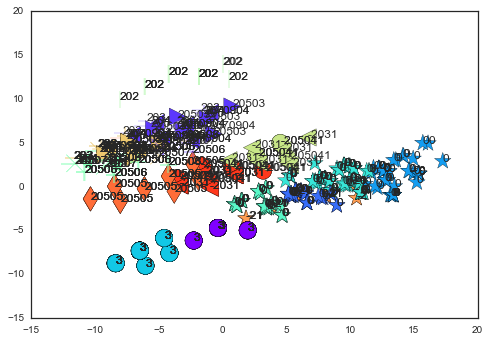

(0.77995589406291965, 0.64729593986344347, 0.0, 0.056997452775757795)

In [50]:
check_perf(chi, role_id)

In [46]:
role_id

[-21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -21,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -2031,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -205041,
 0,
 0,
 0,
 0,
 -

In [84]:
list_shapes = [["house"]] * n_shapes +[["star",8]]*n_shapes 
if True:
    np.random.shuffle(list_shapes)
    width_basis = 15 * n_shapes 


    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier


    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    time_pts = np.linspace(0,100,101)
    chi, heat, taus = graphwave2(G, 'auto', time_pts)

In [85]:
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, f1_score
from sklearn.cluster import AgglomerativeClustering
def check_perf(chi, role_id):
    nb_clust = len(np.unique(role_id))
    pca = PCA(n_components=5)
    trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
    #trans_data=chi
    km = KMeans(n_clusters=nb_clust)
    #km= AgglomerativeClustering(n_clusters=nb_clust)
    km.fit(trans_data)
    labels_pred=km.labels_
    nb_clust = len(np.unique(role_id))

    ######## Params for plotting
    cmapx=plt.get_cmap('rainbow')
    x=np.linspace(0,1,nb_clust+1)
    col=[cmapx(xx) for xx in x ]
    markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}
    plt.figure()
    for c in np.unique(role_id):
        indc = [i for i,x in enumerate(role_id) if x==c]
        plt.scatter(trans_data[indc,0], trans_data[indc,1],
                    c=np.array(col)[list(np.array(labels_pred)[indc])],
                    marker=markers[c%len(markers)], s=300)

    labels = role_id
    for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
                plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()


    return (homogeneity_score(role_id,labels_pred), completeness_score(role_id,labels_pred),
           f1_score(role_id,labels_pred, average='weighted'), silhouette_score(chi,role_id))
    



In [86]:
mapping= {u: i for i,u in enumerate(np.unique(role_id))}
GT_labels = [mapping[l] for l in role_id]

In [87]:
time_pts

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.])

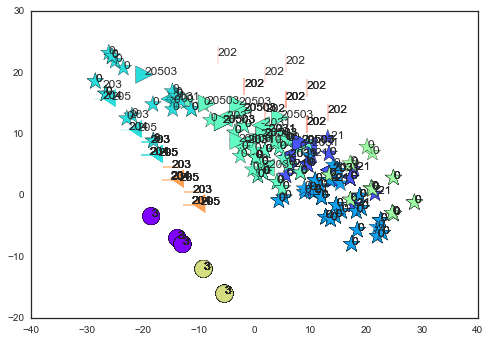

(0.70111212447094706, 0.53876433403235202, 0.0, 0.14601485091441477)

In [88]:
check_perf(chi, role_id)

0


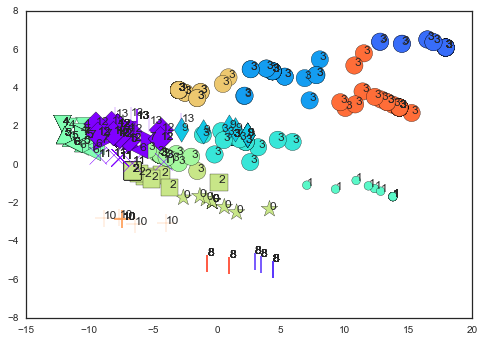

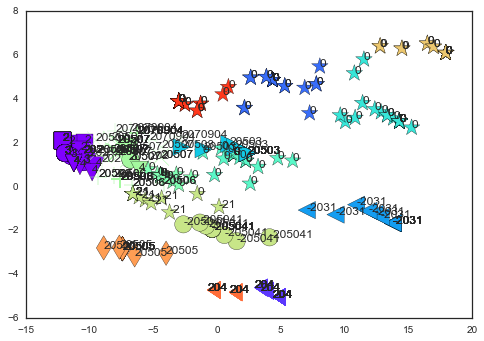

Creating Vertex Features matrix


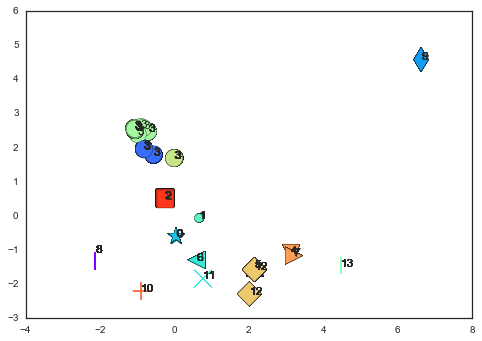

(0.95844629675482396, 0.86232550257972229, 0.0, 0.84568882833162651)
(570, [570, 15.326298952102661, 3.2504305852699731, 14.140495999678038, (0.79807737042580751, 0.69970272483964202, 0.0, 0.18015713536246683)], (570, 100))
0


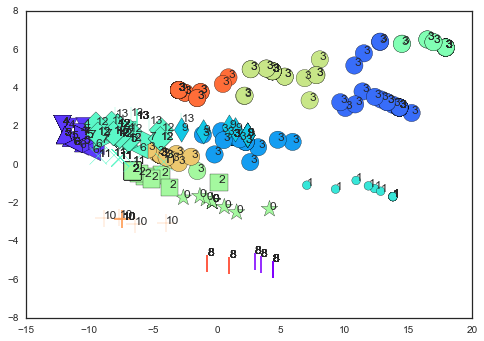

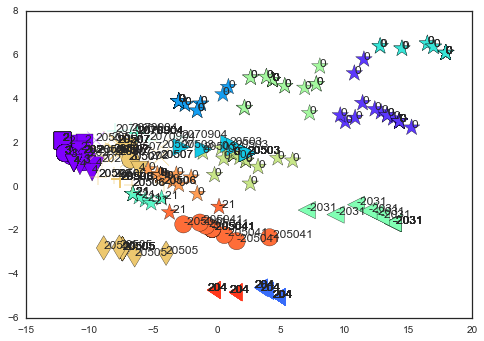

Creating Vertex Features matrix


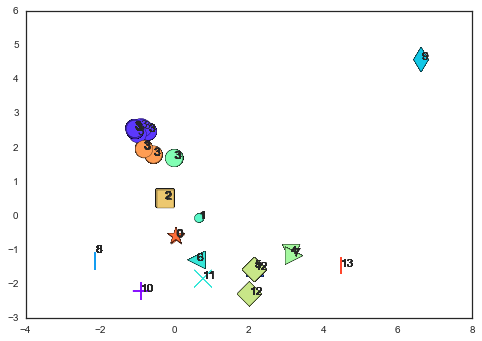

(0.95844629675482396, 0.86232550257972218, 0.026315789473684209, 0.84568882833162651)
(570, [570, 18.674919843673706, 3.2504305852682269, 14.140495999670442, (0.79409757573734274, 0.69537485084369077, 0.0, 0.18015714737061167)], (570, 100))
3
159 128
211 278
459 201


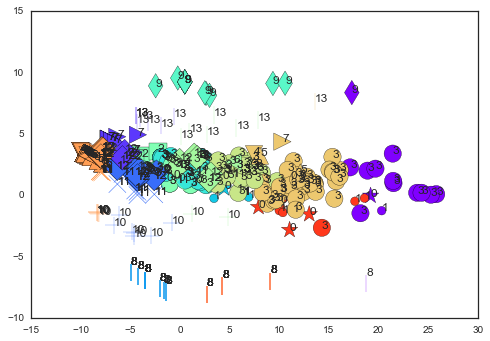

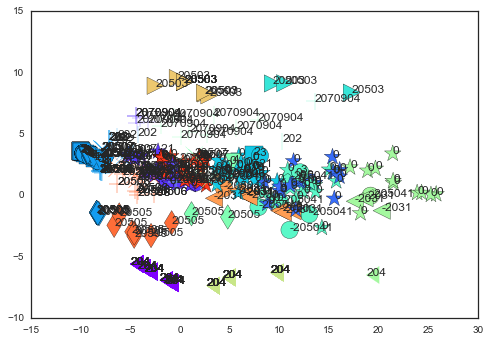

Creating Vertex Features matrix


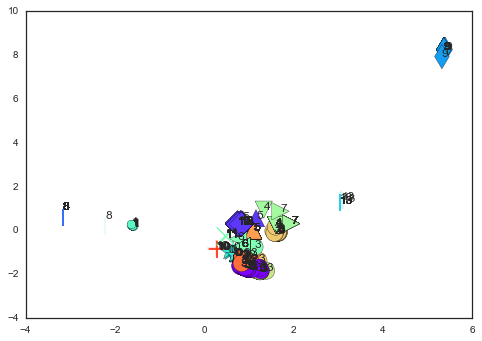

(0.9297250245086196, 0.81290355166715622, 0.0, 0.74757509980873649)
(570, [570, 20.114625930786133, 2.392925855787531, 10.410054177015843, (0.66429391460032983, 0.59377445599144063, 0.021204089360090873, -0.11060954079662895)], (570, 100))
6
543 384
245 182
418 539
85 184
189 436
223 255


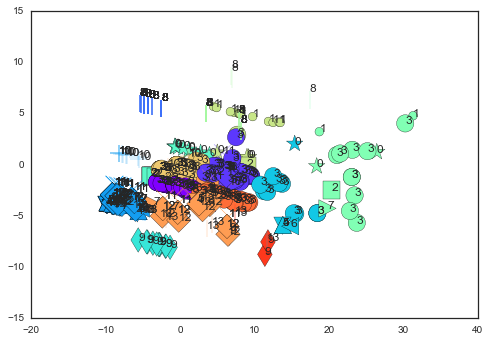

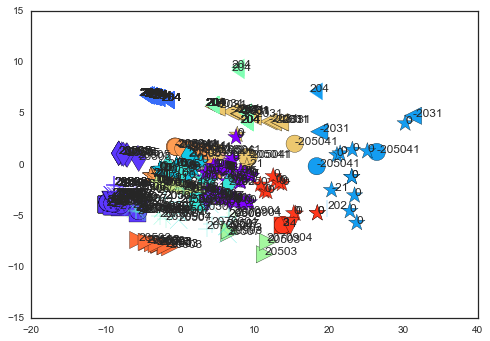

Creating Vertex Features matrix


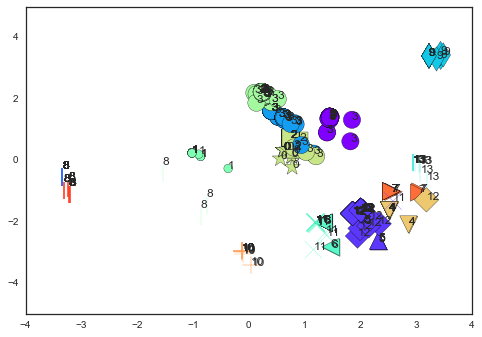

(0.89392393826784422, 0.77786744184805412, 0.16929370444052119, 0.68834702632258693)
(570, [570, 13.010370969772339, 1.6847998692297901, 7.3294614932141897, (0.66396700120136531, 0.59654544003698728, 0.18115055079559361, -0.14320187163772405)], (570, 100))
20
374 9
64 291
8 188
313 519
37 505
387 205
28 100
38 89
55 166
168 277
154 482
138 556
342 349
198 555
84 388
401 561
261 554
365 319
346 161
114 431


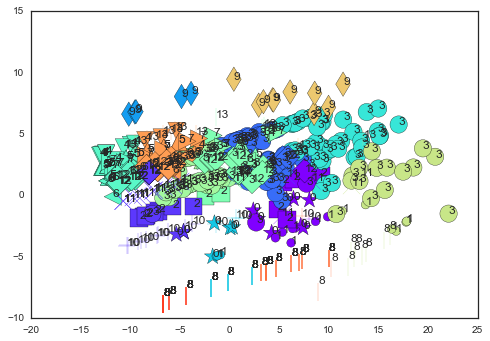

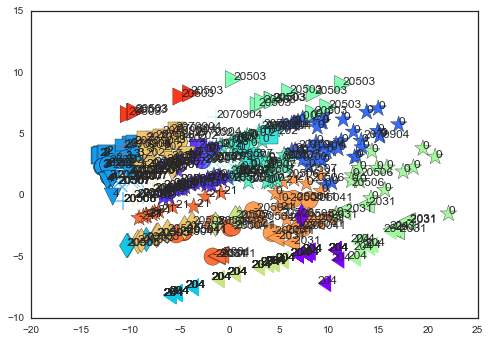

Creating Vertex Features matrix


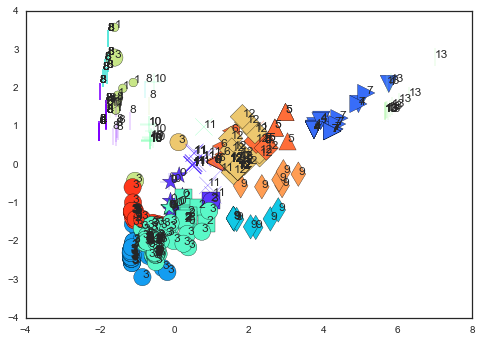

(0.84345913967893738, 0.75236681518365534, 0.1012458451899854, 0.3756464343619409)
(570, [570, 13.319797992706299, 0.97170449144143489, 4.2272502407417347, (0.63283640316982692, 0.52165003145729805, 0.021929824561403504, -0.22464006597317163)], (570, 100))
34
344 558
46 239
259 42
318 506
516 350
162 156
354 267
150 518
392 472
243 89
354 450
54 344
403 362
550 396
49 280
464 169
344 493
29 454
347 246
546 243
331 483
375 455
516 196
166 438
513 166
453 243
297 142
10 348
419 121
392 272
349 424
554 216
469 271
288 402


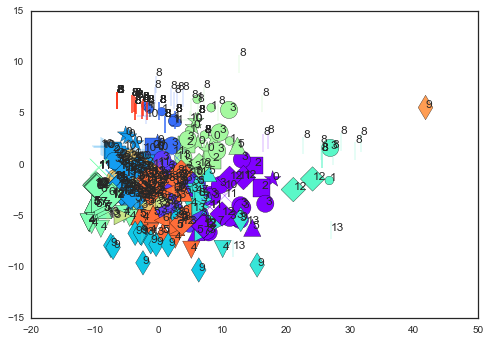

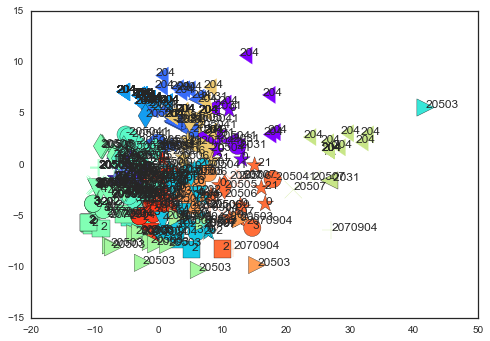

Creating Vertex Features matrix


KeyboardInterrupt: 

In [90]:
import time 
from graphwave.roleX import *
time_alg=[]
time_algRolX=[]
time_pts = list(np.arange(0, 100,4))
n_shapes = 15
n_edges = 0
for add_edges_pct in [0, 0.1,0.5,1.0,3.0,5.0,7.5,10.0,12.5,15.0,20.0,25.0]:
    ### 1. Choose the basis (cycle, torus or chain)
    list_shapes = [["house"]] * n_shapes +[["star",10]]*n_shapes + [["fan",6]]*n_shapes
    width_basis = 15 * n_shapes 

    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier

    ### 4. Pass all these parameters to the Graph Structure
    add_edges = int(add_edges_pct*1.0 /100 * n_edges)
    print(add_edges)
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    mapping= {u: i for i,u in enumerate(np.unique(role_id))}
    GT_labels = [mapping[l] for l in role_id]
    if add_edges_pct == 0:
        n_edges = G.number_of_edges()
    tic =time.time()
    chi, _ ,taus =graphwave2(G, 'auto', time_pts, verbose=False)
    toc =time.time() 
    temp = check_perf(chi, GT_labels)
    time_alg+=[[G.number_of_nodes(),toc-tic, taus[0], taus[1],check_perf(chi, role_id) ]]
    #np.savetxt("log_scalable.txt", time_alg, fmt="%i, %f, %f, %f")
    
    Adj_graph=nx.adjacency_matrix(G).todense()
    Gi=igraph.Graph.Adjacency((Adj_graph > 0).tolist())
    tic =time.time()
    test_RoleX=extract_rolx_roles(Gi,roles=len(np.unique(role_id)))
    chiX=test_RoleX[0]
    tempX = check_perf(chiX, GT_labels)
    toc =time.time() 
    time_algRolX+=[[G.number_of_nodes(),toc-tic, tempX]]
    print(tempX)
    print(G.number_of_nodes(),time_alg[-1], chi.shape)



In [91]:
 time_algRolX

[[570,
  29.070328950881958,
  (0.95844629675482396, 0.86232550257972229, 0.0, 0.84568882833162651)],
 [570,
  26.94564700126648,
  (0.95844629675482396,
   0.86232550257972218,
   0.026315789473684209,
   0.84568882833162651)],
 [570,
  213.99684309959412,
  (0.9297250245086196, 0.81290355166715622, 0.0, 0.74757509980873649)],
 [570,
  134.7186119556427,
  (0.89392393826784422,
   0.77786744184805412,
   0.16929370444052119,
   0.68834702632258693)],
 [570,
  501.04033398628235,
  (0.84345913967893738,
   0.75236681518365534,
   0.1012458451899854,
   0.3756464343619409)]]

In [92]:
 time_alg

[[570,
  15.326298952102661,
  3.2504305852699731,
  14.140495999678038,
  (0.79807737042580751, 0.69970272483964202, 0.0, 0.18015713536246683)],
 [570,
  18.674919843673706,
  3.2504305852682269,
  14.140495999670442,
  (0.79409757573734274, 0.69537485084369077, 0.0, 0.18015714737061167)],
 [570,
  20.114625930786133,
  2.392925855787531,
  10.410054177015843,
  (0.66429391460032983,
   0.59377445599144063,
   0.021204089360090873,
   -0.11060954079662895)],
 [570,
  13.010370969772339,
  1.6847998692297901,
  7.3294614932141897,
  (0.66396700120136531,
   0.59654544003698728,
   0.18115055079559361,
   -0.14320187163772405)],
 [570,
  13.319797992706299,
  0.97170449144143489,
  4.2272502407417347,
  (0.63283640316982692,
   0.52165003145729805,
   0.021929824561403504,
   -0.22464006597317163)],
 [570,
  13.923490047454834,
  0.63932927126436878,
  2.781303204492215,
  (0.52801581397213904,
   0.46054255411642581,
   0.016051440819242677,
   -0.11728918130727255)]]

In [62]:
chi, heat_print, taus=graphwave(G, taus='automatic', verbose=False)

2018-05-23 01:25:57,482:[INFO](pygsp.filters.filter.__init__): Heat : has to compute lmax


[0.5, 0.69999999999999996, 0.89999999999999991, 1.0999999999999999]


In [84]:

import copy
import math
def compute_cheb_coeff(scale, order):
    coeffs = [(-scale)**k * 1.0 / math.factorial(k) for k in range(order + 1)]
    return coeffs

def compute_cheb_coeff_basis(scale, order):
    xx = np.array([np.cos((2*i-1)*1.0/(2*order) * math.pi) for i in range(1,order+1)])
    basis = [np.ones((1,order)),np.array(xx)]
    for k in range(order + 1-2):
        basis.append(2* np.multiply(xx, basis[-1]) - basis[-2])
    basis = np.vstack(basis)
    f = np.exp(-scale*(xx+1))
    products = np.einsum("j,ij->ij",f,basis)
    coeffs = 2.0/(order)*products.sum(1)
    coeffs[0] = coeffs[0]/2
    return list(coeffs)




def heat_diffusion_ind(graph, taus=[1, 10, 25, 50], diff_type='heat',order = 10, proc = 'approximate'):
    '''
    This method computes the heat diffusion waves for each of the nodes
    INPUT:
    -----------------------
    graph    :    Graph, can be of type networkx or pygsp
    taus     :    list of 4 scales for the wavelets. The higher the tau,
                  the better the spread
    order    :    order of the polynomial approximation

    OUTPUT:
    -----------------------
    heat     :     tensor of length  len(tau) x n_nodes x n_nodes
                   where heat[tau,:,u] is the wavelet for node u
                   at scale tau
    '''
    # Compute Laplacian 
    
    a = nx.adjacency_matrix(graph)
    n_nodes, _ = a.shape
    thres = np.vectorize(lambda x : x if x > 0.001*1.0/n_nodes else 0)
    lap = laplacian(a)
    n_filters = len(taus)
    if proc == 'exact':
        lamb, U = np.linalg.eigh(lap.todense())
        heat = {}
        for i in range(n_filters):
             heat[i] = U.dot(np.diagflat(np.exp(-taus[i]*lamb).flatten())).dot(U.T)
    else:
        heat = {i: sc.sparse.csc_matrix((n_nodes, n_nodes)) for i in range(n_filters) }
        #monome = {0: sc.sparse.eye(n_nodes)}
        #for k in range(1, order + 1):
        #     monome[k] = lap.dot(monome[k-1])
        monome = {0: sc.sparse.eye(n_nodes), 1: lap - sc.sparse.eye(n_nodes)}
        for k in range(2, order + 1):
             monome[k] = 2 * (lap - sc.sparse.eye(n_nodes)).dot(monome[k-1]) - monome[k - 2]
        for i in range(n_filters):
            coeffs = compute_cheb_coeff_basis(taus[i], order)
            #print(coeffs)
            heat[i] = sc.sum([  coeffs[k] * monome[k]  for k in range(0, order + 1)])
            index = heat[i].nonzero
            temp = thres(heat[i].A)
            heat[i] = sc.sparse.csc_matrix(temp)
            #### trim the data:
            
             #for k in range(0, order + 1):
                 #heat[i] +=  coeffs[k] * monome[k] 
    return heat, taus




In [85]:
test, _ =heat_diffusion_ind(G)


In [ ]:
test

In [4]:
def charac_function(time_points, temp):
#time_points= np.linspace(0,100,101)
#if True
    sig = []
    for t in time_points:
        complexify = np.vectorize( lambda x: np.exp(-np.complex(0,t*x)))
        sig.append(complexify(temp.A).mean(0))
    sig = np.vstack(sig)
    final_sig = np.zeros((2*sig.shape[0],sig.shape[1]))
    final_sig[::2,:] = np.real(sig)
    final_sig[1::2,:]= np.imag(sig)
    return final_sig

def charac_function_multiscale(heat, time_points):
    final_sig = []
    for i in heat.keys():
        final_sig.append(charac_function(time_points, heat[i]))
    return np.vstack(final_sig).T
        

In [31]:
def laplacian(a):
        n_nodes, _ = a.shape
        posinv = np.vectorize(lambda x: 1.0/np.sqrt(x) if x>1e-10 else 1)
        d = sc.sparse.diags(np.array(posinv(a.sum(0))).reshape([-1,]),0)
        lap = sc.sparse.eye(n_nodes) - d.dot(a.dot(d))
        return lap
    
def graphwave2(graph, taus, time_pnts, type_graph="nx",
              verbose=False, **kwargs):
    ''' wrapper function for computing the structural signatures using GraphWave
    INPUT
    --------------------------------------------------------------------------------------
    graph      :   nx or pygsp Graph
    time_pt    :   time points at which to evaluate the characteristic function
    taus       :   list of scales that we are interested in. Alternatively,
                   'automatic' for the automatic version of GraphWave
    type_graph :   type of the graph used (either one of 'nx' or 'pygsp')
    verbose    :   the algorithm prints some of the hidden parameters
                   as it goes along
    OUTPUT
    --------------------------------------------------------------------------------------
    chi        :  embedding of the function in Euclidean space
    heat_print :  returns the actual embeddings of the nodes
    taus       :  returns the list of scales used.
    '''
    if taus == 'auto':
        a = nx.adjacency_matrix(G)
        lap = laplacian(a)
        l1 = sc.sparse.linalg.eigsh(lap, 2,  which='SM',return_eigenvectors=False)[0]
        smax = -np.log(0.75) * np.sqrt( 0.5 / l1)
        smin = -np.log(0.99) * np.sqrt( 0.5 / l1)
        taus = np.linspace(smin, smax, 4)
    heat_print, _ = heat_diffusion_ind(graph, list(taus), diff_type='heat', order=50, proc = 'approximate')
    chi = charac_function_multiscale(heat_print, time_pnts)

    return chi



In [19]:
chi = graphwave2(G, 'auto')

KeyboardInterrupt: 

In [7]:
chi.shape

(40, 1020)

We now visualize the resulting embeddings by computing their PCA projections. We also run KMeans to assess how well the signatures that we have here generated enable the recovery of structural roles.

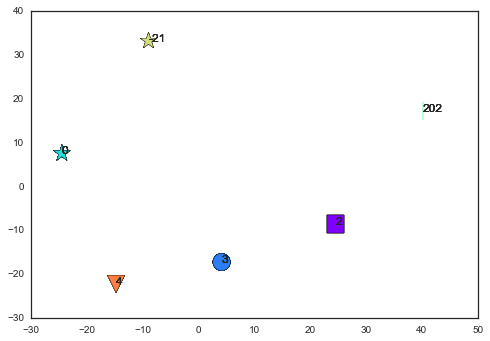

In [8]:
nb_clust = len(np.unique(role_id))
pca = PCA(n_components=5)
trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
km = KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_

######## Params for plotting
cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,nb_clust+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}

for c in np.unique(role_id):
    indc = [i for i,x in enumerate(role_id) if x==c]
    plt.scatter(trans_data[indc,0], trans_data[indc,1],
                c=np.array(col)[list(np.array(labels_pred)[indc])],
                marker=markers[c%len(markers)], s=300)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

In [ ]:
labels_pred

#### Uniscale GraphWave: Hand-selected value for tau

In [35]:
heat

NameError: name 'heat' is not defined

In [ ]:
### Select a scale of interest (here we select a particular range of scale. See associated paper for 
### guidelines on how to select the appropriate scale.)


time_pts = list(np.arange(0,50,0.5))
chi =graphwave2(G, taus = [1], time_pts=time_pts, verbose=False)
print(chi.shape, len(time_pts))

Note that in the EPFL implementation, by construction, the wavelet scales are all divided by the maximum eigenvalue $\lambda_N$.

In [ ]:
list(np.arange(0, 10,0.5)) +list(np.arange(10,100,10))

In [36]:

time_pts = list(np.arange(0, 10,0.5)) +list(np.arange(10,110,10))
chi =graphwave2(G, 'auto', time_pts)
nb_clust=len(np.unique(role_id))
pca=PCA(n_components=5)
trans_data=pca.fit_transform(StandardScaler().fit_transform(chi))
km=KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_


cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,np.max(labels_pred)+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}


for c in np.unique(role_id):
        indc=[i for i,x in enumerate(role_id) if x==c]
        _ = plt.scatter(trans_data[indc,0], trans_data[indc,1],c=np.array(col)[list(np.array(labels_pred)[indc])] ,marker=markers[c%len(markers)],s=500)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            _ = plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

KeyboardInterrupt: 

### Scalability experiment

In [9]:
np.arange(10,5000,25)

array([  10,   35,   60,   85,  110,  135,  160,  185,  210,  235,  260,
        285,  310,  335,  360,  385,  410,  435,  460,  485,  510,  535,
        560,  585,  610,  635,  660,  685,  710,  735,  760,  785,  810,
        835,  860,  885,  910,  935,  960,  985, 1010, 1035, 1060, 1085,
       1110, 1135, 1160, 1185, 1210, 1235, 1260, 1285, 1310, 1335, 1360,
       1385, 1410, 1435, 1460, 1485, 1510, 1535, 1560, 1585, 1610, 1635,
       1660, 1685, 1710, 1735, 1760, 1785, 1810, 1835, 1860, 1885, 1910,
       1935, 1960, 1985, 2010, 2035, 2060, 2085, 2110, 2135, 2160, 2185,
       2210, 2235, 2260, 2285, 2310, 2335, 2360, 2385, 2410, 2435, 2460,
       2485, 2510, 2535, 2560, 2585, 2610, 2635, 2660, 2685, 2710, 2735,
       2760, 2785, 2810, 2835, 2860, 2885, 2910, 2935, 2960, 2985, 3010,
       3035, 3060, 3085, 3110, 3135, 3160, 3185, 3210, 3235, 3260, 3285,
       3310, 3335, 3360, 3385, 3410, 3435, 3460, 3485, 3510, 3535, 3560,
       3585, 3610, 3635, 3660, 3685, 3710, 3735, 37

In [ ]:
import time 
time_alg=[]
time_pts = list(np.arange(0,10,0.5)) + list(np.arange(10,110,10)) 
for n_shapes in np.arange(10,5000,25):
    ### 1. Choose the basis (cycle, torus or chain)
    list_shapes = [["house"]] * n_shapes
    width_basis = 4 * n_shapes 

    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier
    sb.set_style('white')

    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    tic =time.time()
    chi =graphwave2(G, 'auto', time_pts, verbose=False)
    toc =time.time() 
    time_alg.append(toc-tic)
    print(G.number_of_nodes(),time_alg[-1], chi.shape)
    

(90, 2.272922992706299, (90, 240))
(315, 26.121266841888428, (315, 240))
(540, 91.55953407287598, (540, 240))
(765, 194.64284420013428, (765, 240))
(990, 292.62941098213196, (990, 240))
(1215, 473.310791015625, (1215, 240))
(1440, 580.7945530414581, (1440, 240))
(1665, 831.6506588459015, (1665, 240))
(1890, 1013.45339179039, (1890, 240))
(2115, 1132.4784269332886, (2115, 240))
(2340, 1394.946408033371, (2340, 240))
(2565, 1679.3355889320374, (2565, 240))
(2790, 1979.6715250015259, (2790, 240))
(3015, 2308.3219091892242, (3015, 240))
(3240, 2671.358288049698, (3240, 240))
(3465, 3048.7422091960907, (3465, 240))
(3690, 3478.4642791748047, (3690, 240))
(3915, 3893.762937068939, (3915, 240))
(4140, 5884.750511884689, (4140, 240))
(4365, 5840.746036052704, (4365, 240))
(4590, 6041.21024107933, (4590, 240))
(4815, 11909.925003051758, (4815, 240))


In [30]:
chi.shape

(765, 102)

In [28]:
len(time_pts)*2*3

180

## III. Visualizing the Characteristic functions

We now propose to show how to visualize characteristic functions.


In [ ]:
mapping = {u: i for i,u in enumerate(np.unique(role_id))}
cmap=plt.get_cmap('gnuplot')
role_id_plot=[cmap(x) for x in np.linspace(0,1,len(np.unique(role_id)))]
plt.figure()
ind_x=range(chi[0].shape[0])[0::2]
ind_y=range(chi[0].shape[0])[1::2]
for i in np.random.choice(range(G.number_of_nodes()),10,replace=False):
    _ = plt.plot(chi[i,ind_x],chi[i,ind_y],label=str(i),color=role_id_plot[mapping[role_id[i]]])

_ = plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
